In [56]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [4]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

In [6]:
########################### Vars
#################################################################################
TARGET = 'sales'         # Our main target
END_TRAIN = 1913         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns

In [7]:
########################### Load Data
#################################################################################
print('Load Main Data')

data_path = "/Volumes/ExtData/datasets/m5-forecasting-accuracy"

# Here are reafing all our data 
# without any limitations and dtype modification
train_df = pd.read_csv(f'{data_path}/sales_train_validation.csv')
prices_df = pd.read_csv(f'{data_path}/sell_prices.csv')
calendar_df = pd.read_csv(f'{data_path}/calendar.csv')

Load Main Data


## Explore data a bit first!

In [8]:
train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [10]:
train_df.item_id.unique()

array(['HOBBIES_1_001', 'HOBBIES_1_002', 'HOBBIES_1_003', ...,
       'FOODS_3_825', 'FOODS_3_826', 'FOODS_3_827'], dtype=object)

<AxesSubplot:>

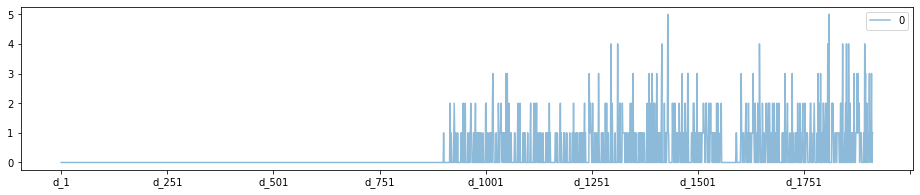

In [11]:
dates = [f"d_{d}" for d in range(1, 1914)]
train_df.iloc[:1][dates].T.plot(figsize=(16,3), alpha=0.5)

In [16]:
# prices_df

In [68]:
calendar_df.columns

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')

In [42]:
date_map = calendar_df[['d', 'date']]
date_map = date_map.set_index('d')

Text(0.5, 0, 'Date')

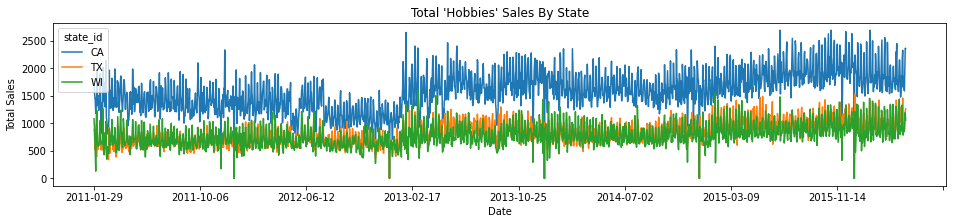

In [65]:
hobbies_sales = train_df.loc[train_df.item_id.str.contains('HOBBIES')].groupby('state_id').sum().T
hobbies_sales.index = [date_map.loc[d][0] for d in hobbies_sales.index]
hobbies_sales.plot(alpha=1.0, figsize=(16, 3))
plt.title("Total 'Hobbies' Sales By State")
plt.ylabel("Total Sales")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

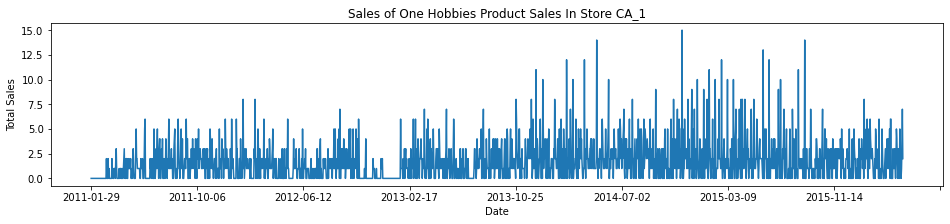

In [67]:
single_df = train_df.iloc[3][dates].T
single_df.index = [date_map.loc[d][0] for d in single_df.index]

single_df.plot(figsize=(16,3), alpha=1.0)
plt.title("Sales of One Hobbies Product Sales In Store CA_1")
plt.ylabel("Total Sales")
plt.xlabel("Date")

<AxesSubplot:>

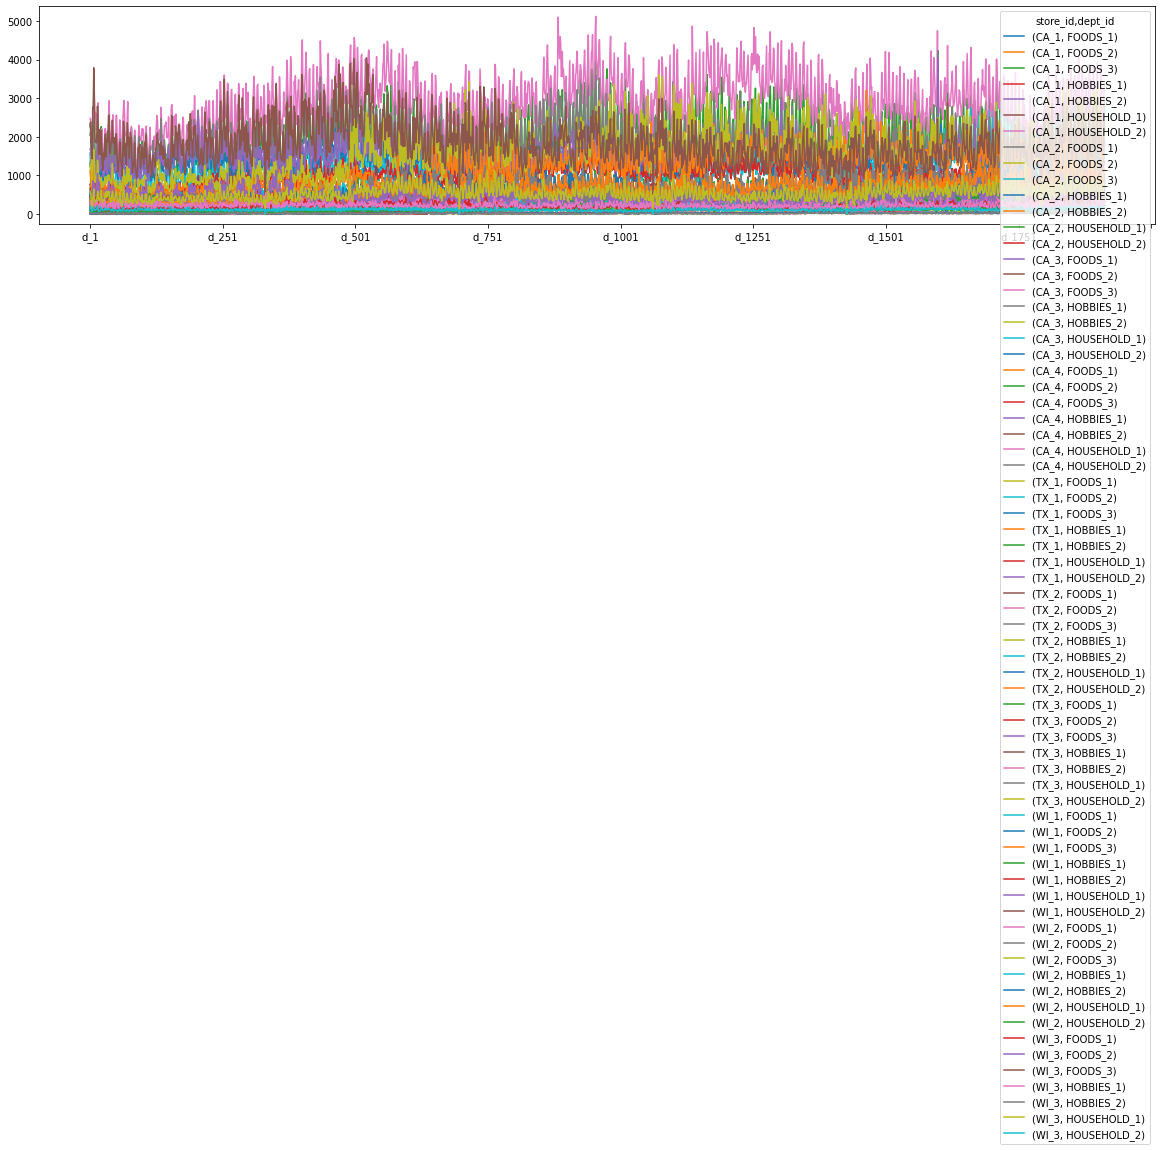

In [29]:
train_df.groupby(['state_id', 'dept_id']).sum().T.plot(figsize=(20,4))